#Imports


In [40]:
%pip install nltk
%pip install langdetect
%pip install spacy
%pip install google-colab
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download fr_core_news_sm
import numpy as np
import pandas as pd
import spacy
import nltk
import string
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from langdetect import detect
from naivebayes import NaiveBayes
from textprocessor import TextProcessor
from crossvalidationmp2 import CrossValidation
from collections import Counter
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
# %pip install nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import wordnet
from sklearn.preprocessing import Normalizer
from nltk.stem.snowball import FrenchStemmer
from nltk.stem import PorterStemmer

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context




#For the off-the-shelf models :
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB


2023-11-20 04:10:29.026471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 04:10:29.026609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 04:10:29.033461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 04:10:31.009207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-11-20 04:10:51.797680: E external/local_xla/xla/stream

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Data Analysis


In [41]:
#We start of by downloading the data from the train.csv and test.csv files
train_corpus = pd.read_csv('/content/train.csv', encoding = 'cp1252' ).sample(frac = 1)
test_corpus = pd.read_csv('/content/test.csv', encoding = 'cp1252' ).sample(frac = 1)
max_features = 3000

In [42]:
train_corpus['labels'], unique_categories = pd.factorize(train_corpus['subreddit'])

In [43]:
#Verify that we only have the wanted categories as categories possible for our subreddits
unique_categories

Index(['Montreal', 'Paris', 'London', 'Toronto'], dtype='object')

Proba of Montreal is 0.25034770514603616
Proba of Paris is 0.25034770514603616
Proba of London is 0.25034770514603616
Proba of Toronto is 0.24895688456189152

The value count of the data is given by the following :

 Montreal    180
Paris       180
London      180
Toronto     179
Name: subreddit, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

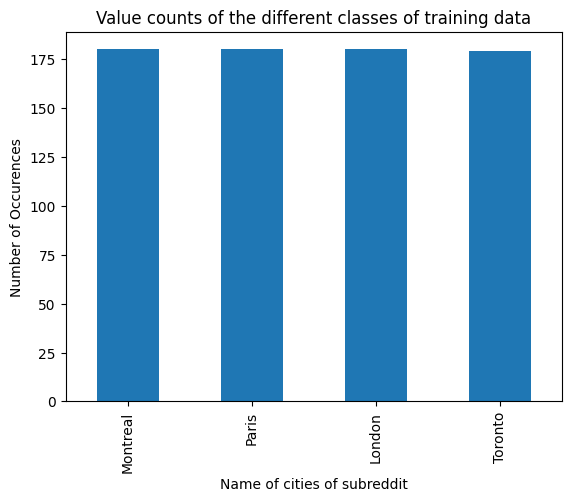

In [44]:
#Plot of distribution of each subreddit within the training data:
valueCount= train_corpus['subreddit'].value_counts()
sum = valueCount.sum()
for key, count in valueCount.items():
    probability = count / sum
    print(f'Proba of {key} is {probability}')



valueCountToPlot = valueCount.iloc[:]

print('\n' "The value count of the data is given by the following :"'\n''\n',valueCount)

valueCountToPlot.plot(kind = 'bar')
plt.title('Value counts of the different classes of training data')
plt.xlabel('Name of cities of subreddit')
plt.ylabel('Number of Occurences')
plt.show

#Text Processing

In [45]:
 #We create POS tags so that we can lemmatise every single word with the approoriate POS tag.

 def get_wordnet_pos(word):
      tag = nltk.pos_tag([word])[0][1][0].upper()
      tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
      return tag_dict.get(tag, wordnet.NOUN)

In [46]:
#We start of by implementing a tokenizer based on lemmatization of the words.
class LemmaTokenizer:
    def __init__(self):
        self.nlp_en = spacy.load('en_core_web_sm')
        self.nlp_fr = spacy.load('fr_core_news_sm')
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return self.lemmatize(doc)

    def __str__(self):
        return "Lemma Tokenizer"

    def detect_language(self, text):
        try:
            lang = detect(text)
            return lang
        except Exception as e:
            return None

    def lemmatize(self, text):
        lang = self.detect_language(text)
        if lang == 'fr':
            return [token.lemma_ for token in self.nlp_fr(text) if token.text.isalpha()]
        else:
            return [self.wnl.lemmatize(t, pos="v") for t in word_tokenize(text) if t.isalpha()]

#we use a TF-IDF vectorizer to re-weight the count features into floating point values suitable for usage by a classifier
class TFIDFVectorizer:
    def __init__(self, documents):
        self.documents = documents
        self.vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.vectorizer.fit_transform(documents)

    def __call__(self, query):
        query_tfidf = self.vectorizer.transform([query])
        feature_names = self.vectorizer.get_feature_names_out()
        tfidf_scores = []
        for col in query_tfidf.nonzero()[1]:
            term = feature_names[col]
            score = query_tfidf[0, col]
            tfidf_scores.append((term, score))
        tfidf_scores.sort(key=lambda x: x[1], reverse=True)
        return tfidf_scores

#We start of by implementing a tokenizer based on stemming of the words.
class StemTokenizer:
    def __init__(self):
        self.wnl_en = PorterStemmer()
        self.wnl_fr = SnowballStemmer('french')

    def __call__(self, doc):
        return self.stem(doc)

    def __str__(self):
        return "Stemming Tokenizer"

    def detect_language(self, text):
        try:
            lang = detect(text)
            return lang
        except Exception as e:
            return None

    def stem(self, text):
        lang = self.detect_language(text)
        if lang == 'fr':
            return [self.wnl_fr.stem(t) for t in word_tokenize(text) if t.isalpha()]
        else:
            return [self.wnl_en.stem(t) for t in word_tokenize(text) if t.isalpha()]

class New_LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t, pos= get_wordnet_pos(t)) for t in word_tokenize(doc) if t.isalpha()]


In [47]:
vectorizer = CountVectorizer()

french_stop_words = set(stopwords.words('french'))
english_stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
combined_stop_words = list(french_stop_words.union(english_stop_words).union(punctuation))

vectorizer = CountVectorizer(stop_words = combined_stop_words, tokenizer = LemmaTokenizer(), binary = True, max_features= 3000)
X_train = vectorizer.fit_transform(train_corpus.to_numpy().T[0])


X_train_vec = X_train.toarray()
X_train_vec

Y_train = train_corpus['labels'].to_numpy()

#Naive Bayes with 10 fold Cross Validation

In [ ]:
# 10 folds Cross Validation:
tfidf = normalization = smooth = [True, False]
features, tokens = np.linspace(1000, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()]
accuracies_NB, count, execution = {}, 1, {}
for t in tfidf:
    for normal in normalization:
        for s in smooth:
            for n in features:
                for token in tokens:
                    start = time.time()
                    label = f'TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}'
                    processor = TextProcessor(True, True, t, token, normal, n)
                    X = processor.trainX(train_corpus)
                    model, validation = NaiveBayes(s), CrossValidation(5)
                    accuracies_NB[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
                    end = time.time()
                    step = end - start
                    execution[label] = step
                    print(f'Iteration {count} out of 120 with TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}')
                    print(f'Iteration {count} was {step} s long')
                    count += 1

In [ ]:
u_NB = max(accuracies_NB, key = accuracies_NB.get)
accuracies_NB[u_NB]

In [ ]:
u_NB

#Decision Tree Classifier

In [ ]:
#Also using 10 nested fold cross validation on the Decision Tree, with no TF-IDF and no tokenizer


n_features, max_depth = np.linspace(1000, max_features, 5, dtype = int), [2,4,6,8,10,12]
accuracies_DT = {}
executions_DT = {}
count = 1
for n in n_features:
    for depth in max_depth:
        classifier, processor = DecisionTreeClassifier(max_features = n, max_depth = depth), TextProcessor(True, True, False, None, False, 2500)
        start = time.time()
        label = f'Number of features = {n} | Maximum depth = {depth}'
        X = processor.trainX(train_corpus)
        validation = CrossValidation(10)
        accuracies_DT[label] = validation.validate(classifier, X, Y_train, False, unique_categories, False)
        end = time.time()
        step = end - start
        executions_DT[label] = step
        print(f'Iteration {count} out of 120 with Number of features = {n} | Maximum depth = {depth}')
        print(f'Iteration {count} was {step} s long')
        count += 1




In [ ]:
u_DT_1 = max(accuracies_DT, key = accuracies_DT.get)
u_DT_1

In [ ]:
#10 folds CV on Decision Tree Classifier with TF-IDF and Lemma tokenizer
n_features, max_depth = np.linspace(1000, max_features, 5, dtype = int), [2,4,6,8,10,12]
accuracies_DT_2 = {}
executions_DT_2 = {}
token = LemmaTokenizer()
count = 1
for n in n_features:
    for depth in max_depth:
        classifier, processor = DecisionTreeClassifier(max_features = n, max_depth = depth), TextProcessor(True, True, True, token, False, 2500)
        start = time.time()
        label = f'Number of features = {n} | Maximum depth = {depth}'
        X = processor.trainX(train_corpus)
        validation = CrossValidation(10)
        accuracies_DT_2[label] = validation.validate(classifier, X, Y_train, False, unique_categories, False)
        end = time.time()
        step = end - start
        executions_DT_2[label] = step
        print(f'Iteration {count} out of 120 with Number of features = {n} | Maximum depth = {depth}')
        print(f'Iteration {count} was {step} s long')
        count += 1

In [ ]:
u_DT_2 = max(accuracies_DT_2, key = accuracies_DT_2.get)
u_DT_2

In [ ]:
accuracies_DT[u_DT_2]

In [30]:
processor = TextProcessor(True, True, True, None, True, 2500)
X = processor.trainX(train_corpus)
model, validation = DecisionTreeClassifier(max_features = 2500, max_depth = 12), CrossValidation(10)
accuracies_max_LR = validation.validate(model, X, Y_train, False, unique_categories, True)

Best accuracy of DecisionTreeClassifier(max_depth=12, max_features=2500) is : 51.39 %


#Logistic Regression

In [48]:
#Linear Regression


# 10 folds Cross Validation:
tfidf = normalization = smooth = [True, False]
features, tokens = np.linspace(1000, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()]
accuracies_LR, count, execution = {}, 1, {}
for t in tfidf:
    for normal in normalization:
        for s in smooth:
            for n in features:
                for token in tokens:
                    start = time.time()
                    label = f'TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}'
                    processor = TextProcessor(True, True, t, token, normal, n)
                    X = processor.trainX(train_corpus)
                    model, validation = LogisticRegression(), CrossValidation(5)
                    accuracies_LR[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
                    end = time.time()
                    step = end - start
                    execution[label] = step
                    print(f'Iteration {count} out of 120 with TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}')
                    print(f'Iteration {count} was {step} s long')
                    count += 1

Averrage accuracy of LogisticRegression() is : 58.97 %
Iteration 1 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 1 was 2.286015033721924 s long
Averrage accuracy of LogisticRegression() is : 61.48 %
Iteration 2 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 2 was 21.325260877609253 s long
Averrage accuracy of LogisticRegression() is : 61.33 %
Iteration 3 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 3 was 12.161352396011353 s long
Averrage accuracy of LogisticRegression() is : 62.87 %
Iteration 4 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 4 was 1.6143052577972412 s long
Averrage accuracy of Log

KeyboardInterrupt: ignored

In [ ]:
u_LR = max(accuracies_LR, key = accuracies_LR.get)
accuracies_LR[u_LR]

In [ ]:
u_LR

In [49]:

processor = TextProcessor(True, True, True, New_LemmaTokenizer(), True, 3500)
X = processor.trainX(train_corpus)
model, validation = LogisticRegression(), CrossValidation(10)
accuracies_max_LR = validation.validate(model, X, Y_train, False, unique_categories, True)


Best accuracy of LogisticRegression() is : 61.97 %


#LDA

In [ ]:
#LDA


# 10 folds Cross Validation:
tfidf = normalization = smooth = [True, False]
features, tokens = np.linspace(1000, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()]
accuracies_LDA, count, execution = {}, 1, {}
for t in tfidf:
    for normal in normalization:
        for s in smooth:
            for n in features:
                for token in tokens:
                    start = time.time()
                    label = f'TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}'
                    processor = TextProcessor(True, True, t, token, normal, n)
                    X = processor.trainX(train_corpus)
                    model, validation = LinearDiscriminantAnalysis(), CrossValidation(5)
                    accuracies_LDA[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
                    end = time.time()
                    step = end - start
                    execution[label] = step
                    print(f'Iteration {count} out of 120 with TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}')
                    print(f'Iteration {count} was {step} s long')
                    count += 1

In [ ]:
u_LDA = max(accuracies_LDA, key = accuracies_LDA.get)
accuracies_LDA[u_LDA]

In [ ]:
u_LDA

In [50]:


processor = TextProcessor(True, True, True, New_LemmaTokenizer(), True, 2000)
X = processor.trainX(train_corpus)
model, validation = LinearDiscriminantAnalysis(), CrossValidation(10)
accuracies_max_KNN = validation.validate(model, X, Y_train, False, unique_categories, True)
accuracies_max_KNN

Best accuracy of LinearDiscriminantAnalysis() is : 57.75 %


0.5774647887323944

#KNN

In [ ]:
#Using KNN :


# 10 folds Cross Validation:
tfidf = normalization = smooth = [True, False]
features, tokens,neighbours = np.linspace(1000, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()],[3,5,7,10]
accuracies_KNN, count, execution = {}, 1, {}
for t in tfidf:
    for normal in normalization:
        for s in smooth:
            for n in features:
                for token in tokens:
                  for N in neighbours:
                    start = time.time()
                    label = f'TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token} | Number of neighbours = {N}'
                    processor = TextProcessor(True, True, t, token, normal, n)
                    X = processor.trainX(train_corpus)
                    model, validation = KNeighborsClassifier(n_neighbors = N), CrossValidation(10)
                    accuracies_KNN[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
                    end = time.time()
                    step = end - start
                    execution[label] = step
                    print(f'Iteration {count} out of 120 with TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}')
                    print(f'Iteration {count} was {step} s long')
                    count += 1

In [ ]:

u_KNN = max(accuracies_KNN, key = accuracies_KNN.get)
accuracies_KNN[u_KNN]

In [ ]:

u_KNN

In [51]:

processor = TextProcessor(True, True, True, StemTokenizer(), True, 3500)
X = processor.trainX(train_corpus)
model, validation = KNeighborsClassifier(n_neighbors = 10), CrossValidation(10)
accuracies_max_KNN = validation.validate(model, X, Y_train, False, unique_categories, True)
accuracies_max_KNN

Best accuracy of KNeighborsClassifier(n_neighbors=10) is : 63.38 %


0.6338028169014085

#Stacking and Boosting

In [35]:
#Stacking in addition to independant bagging classifiers. Namely,
# a logistic regression, a decision tree, a Gradient Boosting Classifier, a SVC classifier, a GaussionNB() classifier, and a MultinomialNB() classifier.

seed = 0
estmator = 5
bootstrap_value = True
level0 = list()
level0.append(('B_lr', BaggingClassifier(base_estimator= LogisticRegression(C = 0.075), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)))
level0.append(('B_tree', BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth=12,max_features=2500), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)))
level0.append(('B_knn', BaggingClassifier(base_estimator= GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)))
level0.append(('B_svm', BaggingClassifier(base_estimator= SVC(kernel='rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)))
level0.append(('B_naive', BaggingClassifier(base_estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)))
level0.append(('B_naive2', BaggingClassifier(base_estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)))
# define meta learner model
level1 = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators=level0, final_estimator=level1)

processor = TextProcessor(True, True, True, New_LemmaTokenizer(), True)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_Stacking = validation.validate(model, X, Y_train, False, unique_categories, False)
accuracy_Stacking


KeyboardInterrupt: ignored

In [38]:
#Running the previous classifier,


seed = 0
estmator = 5
bootstrap_value = True
level0 = list()
level0.append(('B_lr', LogisticRegression(C = 0.075)))
level0.append(('B_tree',DecisionTreeClassifier(max_depth=12,max_features=2500)))
level0.append(('B_knn', GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0)))
level0.append(('B_svm', SVC(kernel='rbf')))
level0.append(('B_naive', GaussianNB()))
level0.append(('B_naive2', MultinomialNB()))
# define meta learner model
level1 = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators=level0, final_estimator=level1)

processor = TextProcessor(True, True, True, New_LemmaTokenizer(), True)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_Stacking = validation.validate(model, X, Y_train, False, unique_categories, False)
accuracy_Stacking

KeyboardInterrupt: ignored

In [40]:
#Analyzing the accuracy of each seperate model currenlty being stacked in the stacking classifier
processor = TextProcessor(True, True, True,LemmaTokenizer(), True)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)

for name, model in level0:
    print(f"Accuracy for {name}: {validation.validate(model, X, Y_train, False, unique_categories, False)}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/

Averrage accuracy of BaggingClassifier(base_estimator=LogisticRegression(C=0.075),
                  bootstrap_features=True, n_estimators=5, random_state=0) is : 54.5 %
Accuracy for B_lr: 0.5450312989045384


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Averrage accuracy of BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=12,
                                                        max_features=2500),
                  bootstrap_features=True, n_estimators=5, random_state=0) is : 55.63 %
Accuracy for B_tree: 0.556338028169014


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Averrage accuracy of BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10),
                  bootstrap_features=True, n_estimators=5, random_state=0) is : 47.29 %
Accuracy for B_knn: 0.472887323943662


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Averrage accuracy of BaggingClassifier(base_estimator=SVC(), bootstrap_features=True, n_estimators=5,
                  random_state=0) is : 59.66 %
Accuracy for B_svm: 0.5965766823161188


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Averrage accuracy of BaggingClassifier(base_estimator=GaussianNB(), bootstrap_features=True,
                  n_estimators=5, random_state=0) is : 58.68 %
Accuracy for B_naive: 0.5867566510172143


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Averrage accuracy of BaggingClassifier(base_estimator=MultinomialNB(), bootstrap_features=True,
                  n_estimators=5, random_state=0) is : 58.54 %
Accuracy for B_naive2: 0.5854264475743348


In [17]:
#Only implementing boosting on the desicion Tree.
from sklearn.ensemble import AdaBoostClassifier

processor = TextProcessor(True, True, True,LemmaTokenizer(), True)
X = processor.trainX(train_corpus)
model, validation = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = "entropy"), random_state=0), CrossValidation(10)
accuracies_boosting = validation.validate(model, X, Y_train, False, unique_categories, True)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/

Best accuracy of AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                   random_state=0) is : 52.11 %


In [32]:
#Only implementing boosting on the SVM classifier.
from sklearn.ensemble import AdaBoostClassifier

processor = TextProcessor(True, True, True,None, True)
X = processor.trainX(train_corpus)
model, validation = BaggingClassifier(base_estimator= SVC(kernel = 'linear'), n_estimators=10, random_state=0), CrossValidation(10)
accuracies_boosting = validation.validate(model, X, Y_train, False, unique_categories, True)

Best accuracy of BaggingClassifier(base_estimator=SVC(kernel='linear'), random_state=0) is : 64.79 %


In [27]:
#10 folds CV on stacking using the best hyperparameters found earlier and decreasing estmator, linear kernel for svm
# Bagging SVM for the final estimator,
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(n_estimators=500, random_state=0), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)


processor = TextProcessor(True, False, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV16 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV16

Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

0.6550273865414711

In [28]:
#Analyzing the accuracy of each model (seperatly) currently forming the stacking classifier.
processor = TextProcessor(True, False, True,LemmaTokenizer(), True)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)

for name, model in level0:
    print(f"Accuracy for {name}: {validation.validate(model, X, Y_train, False, unique_categories, False)}")

Averrage accuracy of BaggingClassifier(base_estimator=LogisticRegression(C=0.075),
                  bootstrap_features=True, n_estimators=5, random_state=0) is : 52.3 %
Accuracy for B_lr: 0.5230046948356807
Averrage accuracy of BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=12,
                                                        max_features=2500),
                  bootstrap_features=True, n_estimators=5, random_state=0) is : 59.12 %
Accuracy for B_tree: 0.5911580594679186
Averrage accuracy of BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10),
                  bootstrap_features=True, n_estimators=5, random_state=0) is : 46.32 %
Accuracy for B_knn: 0.4632042253521127
Averrage accuracy of BaggingClassifier(base_estimator=SVC(), bootstrap_features=True, n_estimators=5,
                  random_state=0) is : 59.94 %
Accuracy for B_svm: 0.5993935837245696
Averrage accuracy of BaggingClassifier(base_estimator=GaussianNB(), bootstrap_features=Tru

In [29]:
#We have also created a confusion matrix based on the previous iteration to understand which classes were we predicting correctly, and which ones we were not.

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score

ypred = cross_val_predict(classifier, X, Y_train, cv=4)

conf_matrix = confusion_matrix(Y_train, ypred)
accuracy = accuracy_score(Y_train, ypred)

print(f"Confusion Matrix (Iteration {1}):\n{conf_matrix}")
print(f"Accuracy (Iteration {1}): {accuracy * 100:.2f}%")

Confusion Matrix (Iteration 1):
[[131   8  25  16]
 [  0 143   7  29]
 [ 46  48  56  30]
 [  0  43   6 131]]
Accuracy (Iteration 1): 64.12%


In [34]:
from sklearn.ensemble import GradientBoostingClassifier



processor = TextProcessor(True, False, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)


classifier = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0)


model, validation = classifier, CrossValidation(10)
accuracy_StackingV16 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV16

Iteration 1 of 10 - cross fold on the GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=500,
                           random_state=0): Accuracy obtained is 64.79 %
Iteration 2 of 10 - cross fold on the GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=500,
                           random_state=0): Accuracy obtained is 65.28 %
Iteration 3 of 10 - cross fold on the GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=500,
                           random_state=0): Accuracy obtained is 56.94 %
Iteration 4 of 10 - cross fold on the GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=500,
                           random_state=0): Accuracy obtained is 61.11 %
Iteration 5 of 10 - cross fold on the GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=500,
                           random_state=0): Accuracy obtained is 54.17 %
Iteration 6 of 10 - cross fold on the GradientBoostingClassi

0.6203442879499218